In [2]:
import numpy as np
import ants
import matplotlib.pyplot as plt
import os
from antspynet.utilities import brain_extraction
import logging
import gc
import nibabel as nib
import reorient_nii

In [3]:
# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

def porcentagem_limiar(values, thresh): #vê qual o porcentagem de valores acima de um threshold
    if len(values.shape) > 1:
        values = values.flatten()

    thresh_count = 0
    
    for value in values:
        if value > thresh:
            thresh_count += 1

    print(f"TOTAL VOXELS: {len(values)} \nMAIOR QUE {thresh}: {thresh_count} \nrazão: {(thresh_count/len(values))*100:.2f}%")

def metricas_imagem(data): #print metricas de uma imagem (max, min, media)
    if len(data.shape) > 1:
        values = data.flatten()

    print(f"MEDIA: {np.mean(values)}")
    print(f"MIN: {np.min(values)}")
    print(f"MAX: {np.max(values)}")

    plt.hist(values)
    plt.show()

def winsorize_image(image_data, lower_percentile=0, upper_percentile=99.9): #reduz valores extremos
    lower_bound = np.percentile(image_data, lower_percentile)
    upper_bound = np.percentile(image_data, upper_percentile)
    winsorized_data = np.clip(image_data, lower_bound, upper_bound)
    return winsorized_data

def normalize_image_min(image_data): #normalizar 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

# Função para processar uma única imagem
def process_image(img_path, template, registro='Affine', orientation='false'):
    try:
        logger.info(f"Inicio processamento: {img_path}")
        # Carrega a imagem
        image = ants.image_read(img_path,reorient=orientation)

        # Registra pra padronizar shape da imagem
        registration = ants.registration(fixed=template, moving=image, type_of_transform=registro)
        affine_image = registration['warpedmovout']
        brain_masked = affine_image

        # Cria template pra máscara
        # prob_mask = brain_extraction(affine_image, modality='t1')
        # logger.info(f"Template obtido.")

        # # Cria a máscara
        # mask = ants.get_mask(prob_mask, low_thresh=0.5)
        # logger.info(f"Máscara aplicada.")

        # # Máscara do cérebro e extração
        # brain_masked = ants.mask_image(affine_image, mask)
        # logger.info(f"Extração.")

        # Bias Field Correction
        #image = ants.from_numpy(data, origin=image.origin, spacing=image.spacing, direction=image.direction)
        image = ants.n4_bias_field_correction(brain_masked, shrink_factor=2)
        data = image.numpy()
        logger.info(f"Bias Corrigido.")

        # Winsorizing
        data = winsorize_image(data, 0, 99.9)
        logger.info(f"Winsorized.")

        # Normalização
        data = normalize_image_min(data)
        image = ants.from_numpy(data, origin=brain_masked.origin, spacing=brain_masked.spacing, direction=brain_masked.direction)

        logger.info(f"Imagem {img_path} processada.")

        #ants.image_write(image, output_path)
        #logger.info(f"Imagem salva: {os.path.basename(output_path)}")

        gc.collect()

        return image
        
    except Exception as e:
        logger.error(f"Erro ao processar a imagem {img_path}: {e}")
        return None
    
def plot_views(image):
    fig, axs = plt.subplots(1, 3)

    axs[0].imshow(image[80, :, :], cmap='grey')
    axs[0].set_title("esperado: sagital")
    axs[1].imshow(image[:, 80, :], cmap='grey')
    axs[1].set_title("esperado: coronal")
    axs[2].imshow(image[:, :, 80], cmap='grey')
    axs[2].set_title("esperado: axial")
    fig.tight_layout(rect=[0, 0, 1, 0.8])
    plt.show()

In [5]:
nii_path = "oasis_testing.nii.gz" 

dir = '/mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn'

template_path = f"{dir}/Alzheimer-CNN-Detection/pre_processing/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii"
template = ants.image_read(template_path)
mask_path = f"{dir}/Alzheimer-CNN-Detection/pre_processing/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_mask.nii"
mask = ants.image_read(mask_path)

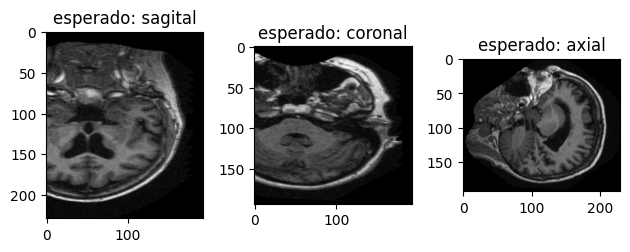

In [6]:
nii_img = ants.image_read('oasis_testing.nii.gz')

registration = ants.registration(fixed=template, moving=nii_img, type_of_transform='Affine')
affine_nii = registration['warpedmovout']

plot_views(affine_nii.numpy())